# Face Alignment

## Архитектура Stacked Hourglass Network

**Hourglass** — это U-Net-подобная структура, которая сначала уменьшает разрешение изображения, затем восстанавливает его обратно. Такая структура напоминает по форме песочные часы (hourglass).

**Stacked Hourglass Network** состоит Hourglass-блоков, каждый из которых старается уточнять результат предыдущего. Несмотря на то, что она придумана в 2016 году, до сих пор используется во многих исследовательских проектах для задачи обнаружения ключевых точек.

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_12.49.50_PM.png)

### Hourglass module

Посмотрим подробнее на структуру **отдельного Hourglass-блока**

![retrt](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_12.50.12_PM.png)

Каждый бокс в этой схеме - это Residual block, который отвечает за извлечение признаков на разных уровнях детализации (вспоминаем про ResNet). Причем, каждый такой блок иммеет одинаковую размерность на входе и на выходе.

Downsampling и upsampling можно делать разными способами.

*   Для Downsampling: nn.MaxPool2d или nn.Conv2d
*   Для Upsampling: nn.Upsample или nn.ConvTranspose2d

Основная разница: maxpool и upsample - необучаемые слои в отличие от сверток. Это может как быть как минусом, так и плюсом: чем больше параметров - тем медленее идет процесс обучения (при этом не факт, что результаты будут лучше).

То есть, идейно все практически также как было в U-net: полностью симметричная архитектура, сначала идет преобразование в более низкоразмерное пространство, а потом декодирование обратно с пробросами результатов из соотвествующих слоев энкодера. Разница лишь в том, что теперь каждый кирпичик - это Residual block.

А вот реализация ResidualBlock вам в помощь!

Но можете ее править под себя, если очень хочется.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

При построении архитектуры Hourglass-блоков **не обязательно полностью повторять архитектуру**, которая представлена на картинке из статьи. Вы можете добавлять больше или меньше модулей, некоторые блоки вообще можно не использовать. В целом, это творческая задача и вы вольны делать так, как вам самим хочется. **Главное - чтобы ваша реализация соотвествовала изначальной идее Hourglass, и итоговые результаты были достаточно хорошими.**

### Stacked Hourglass Network

Как и было сказано ранее, Stacked Hourglass - это набор одинаковых Hourglass блоков (см. схематический рисунок в начале ноутбука). Но что это за блок между каждыми двумя Hourglass? Чтобы ответить на этот вопрос, нужно сначала разобраться с тем, что мы будем получать на выходе такой нейронной сети.

Предсказывать ключевые точки лица можно поразному. Есть два основных подхода:

1.   Регрессия - предсказывает координаты точек лица напрямую -> $(N, x, y)$.
2.   Heatmap - предсказывает карту вероятностей на выходе, а наиболее подходящие точки находятся через argmax

Не вдваясь в подробности, можно просто сказать, что Heatmap-подход показал себя лучше из-за своей устойчивости к шумам и начальным условиям. В качестве функции потерь в таком случае используют обычный **MSE loss**.

В Stacked Hourglass **используется именно heatmap-подход**. И на выходе каждого Hourglass-блока находится слой (голова), который создает heatmap нужного размера. Обычно это какие-то стандартные варианты по типу *Conv -> BatchNorm -> Relu -> Conv* или просто *Conv*. Каждая heatmap'a прокидывается на следующую голову, и они суммируются, и так, пока слои не закончатся.

Такой подход нужен для реализации **Intermediate Supervision**. Если говорить простыми словами, то это такой вариант обучения нейронной сети, когда мы подсчитываем лосс не только по финальному выходу сети, а также на некоторых промежуточных слоях (головах). Градиенты в этом случае тоже распространяются не только через последний выход, но и через промежуточные уровни. Эти головы не влияют на финальное предсказание напрямую, но помогают модели быстрее и лучше учиться. На практике это означет следующее:

Нужно посчитать лосс (таргет для всех одинаковый) для каждой головы отдельно, а потом просуммировать. Далее Pytorch сам построит за вас весь граф вычислений и правильно запустит везде градиенты. В коде это выглядит так:

```
outputs = model(image)  # outputs — список из N heatmaps от разных голов
losses = [loss_function(output, target) for output in outputs]
total_loss = sum(losses)
total_loss.backward()
optimizer.step()
```

Подведем **итоги по архитектуре**.

Stacked Hourglass состоит из Hourglass-блоков, после каждого такого блока идет голова, которая предсказывает heatmap'у. Каждая heatmap'а суммируется с предыдущей. Градиенты при обучении текут с каждой головы, а не только через последний выход сети.

Подробно про Stacked Hourglass Network можно прочитать в [оригинальной статье](https://arxiv.org/pdf/1603.06937).

## Датасет

Есть множество датасетов для этой задачи, но для наших целей должно хватить и [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset). К сожалению или к счастью в разметке там всего 5 точек

1.   Левый глаз
2.   Правый глаз
3.   Нос
4.   Левый уголок рта
5.   Правый уголок рта


Единственная проблема заключается в том, что разметка - это именно точки, а не heatmap'ы. Но можно их сгенерировать самостоятельно при помощи гауссовского распределения вокруг размеченных точек. Вот вам функции в помощь. Можете их тоже редактивовать под себя, если нужно.

Сам по себе CelebA избыточно большой для нашей задачи, поэтому можете использовать только его часть. Также, имеет смысл заранее кропнуть картинки таким образом, чтобы на них остались только лица, ну или по крайней мере минимум всего остального.

## Выравнивание по предсказанным точкам

Существует множество вариантов, как по полученным точкам правильно преобразовать картинку. Главное, что вам нужно понимать - **это задача классического компьютерного зрения** и решается при помощи математики, без нейронок. Вдаваться в подробности конкретных алгоритмов мы не будем.

Можно использовать аффинное преобразование, тогда потребуется только 3 точки, можно, например, искать матрицу гомографии, где может быть использовано больше точек, а может быть, есть еще что-то. Реализовывать эти алгоритмы самим не нужно. Достаточно провести небольшой ресерч и найти готовое решение (но **не готовую нейронку для выравнивания**), лишь бы оно работало. Количество используемых точек тоже выбирайте сами, подойдет любой вариант. Условный ориентир для поиска - библиотека **opencv**.

# План заданий

По итогу, в этом блоке у вас следующие задачи:


*   Реализовать Hourglass блок
*   Реализовать Stacked Hourglass
*   Подготовить датасет, преобразовав точки в Heatmap'ы
*   Обучить модель
*   Найти или реализовать функцию, которая бы по предсказанным ключевым точкам делала бы выравнивание лица на картинке (face alignment)

**P.S. Не забывайте сохранять модели после обучения и выводите промежуточные результаты на экран**



**Удачи! У вас всё получится 💗!**

In [ ]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

### 1. Модель Stacked Hourglass Network

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.skip is not None:
            residual = self.skip(residual)
        out += residual
        return F.relu(out)

class Hourglass(nn.Module):
    def __init__(self, n, channels):
        super(Hourglass, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            ResidualBlock(channels, channels),
            ResidualBlock(channels, channels)
        )
        self.middle = ResidualBlock(channels, channels)
        self.up = nn.Sequential(
            ResidualBlock(channels, channels),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        down = self.down(x)
        middle = self.middle(down)
        up = self.up(middle)
        return up + F.interpolate(middle, scale_factor=2, mode='bilinear', align_corners=True)

class StackedHourglass(nn.Module):
    def __init__(self, n_stacks=2, n_keypoints=5):
        super(StackedHourglass, self).__init__()
        self.n_stacks = n_stacks
        self.n_keypoints = n_keypoints

        self.init_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2),
            ResidualBlock(128, 128),
            ResidualBlock(128, 256)
        )

        self.hourglasses = nn.ModuleList([Hourglass(4, 256) for _ in range(n_stacks)])
        self.out_convs = nn.ModuleList([
            nn.Sequential(
                ResidualBlock(256, 256),
                nn.Conv2d(256, n_keypoints, kernel_size=1)
            ) for _ in range(n_stacks)
        ])

        # skip-связи от выходов heatmap к следующему стеку (только до n-1)
        self.inter_convs = nn.ModuleList([
            nn.Conv2d(n_keypoints, 256, kernel_size=1) for _ in range(n_stacks - 1)
        ])

    def forward(self, x):
        x = self.init_conv(x)
        heatmaps = []

        for i in range(self.n_stacks):
            x = self.hourglasses[i](x)
            heatmap = self.out_convs[i](x)
            heatmaps.append(heatmap)

            # skip-связь к следующему стеку
            if i < self.n_stacks - 1:
                inter = self.inter_convs[i](heatmap)
                x = x + inter

        return heatmaps  # финальный heatmap

### 2. Датасет FaceLandmarksDataset

In [ ]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, images_dir, landmarks_file, nsamples=None, 
                 image_shape=(256, 256), heatmap_size=(64, 64), sigma=2):
        """
            images_dir: Путь к папке с изображениями
            landmarks_file: Путь к файлу с landmarks
            nsamples: Сколько образцов использовать (None = все доступные)
            image_shape: Размер входных изображений
            heatmap_size: Размер heatmap
            sigma: Размер гауссова ядра для heatmap
        """
        self.images_dir = images_dir
        self.image_shape = image_shape
        self.heatmap_size = heatmap_size
        self.sigma = sigma
        
        # Загрузка landmarks и путей к изображениям
        self.image_paths, self.landmarks_list = self._load_landmarks(landmarks_file, nsamples)
        
        # Трансформации изображений
        self.transform = transforms.Compose([
            transforms.Resize(image_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225]),
        ])

    def _load_landmarks(self, landmarks_file, nsamples):
        image_paths = []
        landmarks_list = []
        
        with open(landmarks_file, 'r') as f:
            lines = f.readlines()
            
            # Пропускаем первые 2 строки (заголовки)
            for line in lines[2:]:
                if nsamples is not None and len(image_paths) >= nsamples:
                    break
                    
                parts = line.strip().split()
                if len(parts) != 11:  # 1 имя файла + 10 координат (5 точек)
                    continue
                
                img_name = parts[0]
                image_paths.append(os.path.join(self.images_dir, img_name))
                
                # Преобразуем координаты в числа
                landmarks = list(map(int, parts[1:]))
                landmarks_list.append(landmarks)
        
        return image_paths, landmarks_list

    def __len__(self):
        return len(self.image_paths)
    
    
    def __getitem__(self, idx):
        # Загрузка изображения
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Получаем landmarks
        landmarks = np.array(self.landmarks_list[idx]).reshape(-1, 2).astype(np.float32)
        
        # Масштаб от оригинала (178x218) до (256x256)
        scale_to_input = np.array([self.image_shape[1] / 178, self.image_shape[0] / 218])
        landmarks *= scale_to_input

        # Сохраняем оригинальные landmarks для визуализации
        original_landmarks = torch.from_numpy(landmarks.copy())

        # Масштабируем координаты под размер heatmap (64×64)
        scale_x = self.heatmap_size[1] / self.image_shape[1]
        scale_y = self.heatmap_size[0] / self.image_shape[0]
        scaled_landmarks = landmarks * np.array([scale_x, scale_y])

        # Генерируем heatmaps
        heatmaps = self._landmarks_to_heatmaps(scaled_landmarks)
        heatmaps = torch.FloatTensor(heatmaps)

        # Трансформируем изображение
        image = self.transform(image)

        return image, heatmaps, original_landmarks

    def _landmarks_to_heatmaps(self, landmarks):
        """Генерация heatmap для landmarks"""
        heatmaps = []
        for (x, y) in landmarks:
            hm = self._create_heatmap((self.heatmap_size[0], self.heatmap_size[1]), 
                                    (x, y), self.sigma)
            heatmaps.append(hm)
        return np.array(heatmaps)
    
    def _create_heatmap(self, size, landmark, sigma):
        """Создание одного heatmap с гауссовым распределением (без округления координаты!)"""
        h, w = size
        x, y = landmark
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
        return heatmap

### 3. Визуализация картинок, точек и heatmaps

In [ ]:
def visualize_samples_with_heatmaps(sample_indices, dataset, pred_heatmaps=None, max_per_row=5):
    num_samples = min(len(sample_indices), max_per_row)
    """
    Визуализирует изображения и соответствующие тепловые карты (heatmaps) ключевых точек.
    Предсказанные heatmaps или GT heatmaps
    """

    plt.figure(figsize=(2.5 * max_per_row, 5))  # 2 строки: изображения и heatmaps

    # Первая строка: оригинальные изображения с landmarks
    for i, idx in enumerate(sample_indices[:num_samples]):
        plt.subplot(2, max_per_row, i + 1)

        img_path = dataset.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        plt.imshow(image)

        # GT точки
        landmarks = np.array(dataset.landmarks_list[idx]).reshape(-1, 2)
        plt.scatter(landmarks[:, 0], landmarks[:, 1],
                    s=30, marker='o', facecolors='none', edgecolors='red')

        plt.title(f"Sample {idx}")
        plt.axis('off')

    # Вторая строка: heatmaps (GT из датасета или pred)
    for i, idx in enumerate(sample_indices[:num_samples]):
        plt.subplot(2, max_per_row, max_per_row + i + 1)

        if pred_heatmaps is not None and i < pred_heatmaps.shape[0]:
            # Предсказанные heatmaps
            total_hm = pred_heatmaps[i].sum(dim=0).cpu().numpy()
            plt.imshow(total_hm, cmap='hot')
            plt.title(f"Pred Heatmap {idx}")
        else:
            # GT heatmaps
            # ВАЖНО: dataset[idx] возвращает кортеж из 3 элементов (image, heatmaps, landmarks)
            _, gt_heatmaps, _ = dataset[idx]
            total_hm = gt_heatmaps.sum(dim=0).numpy()
            plt.imshow(total_hm, cmap='hot')
            plt.title(f"GT Heatmap {idx}")

        plt.axis('off')

    plt.tight_layout()
    plt.show()

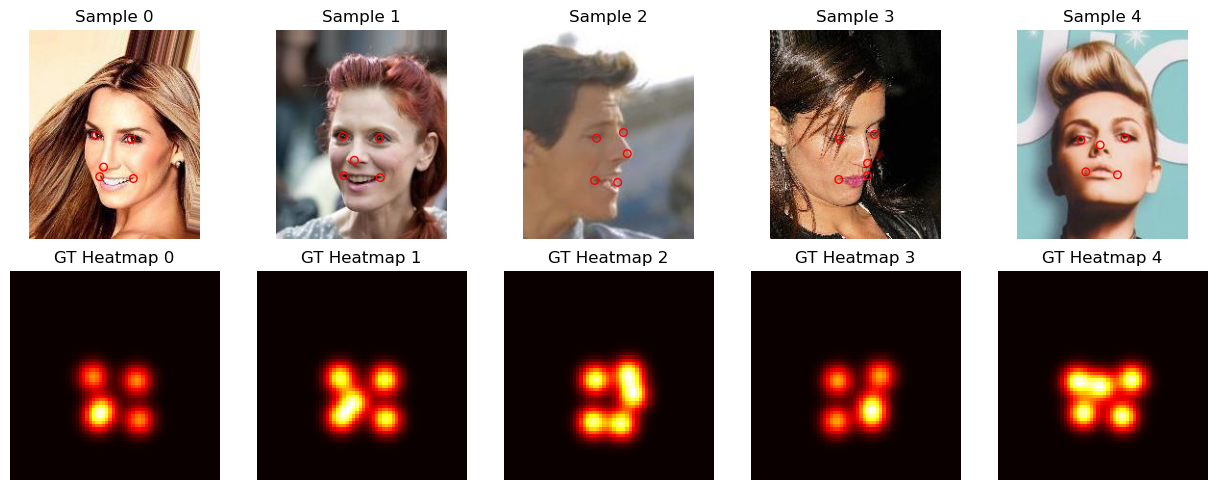

In [40]:
# 4. Загрузка данных
landmarks_file = 'H:/Disk3/Python/Deep_Learning_MFTI_Part1_2025/23.1 Проект/Dataset/celebA/Anno/list_landmarks_align_celeba.txt'
images_dir = 'H:/Disk3/Python/Deep_Learning_MFTI_Part1_2025/23.1 Проект/Dataset/celebA/img_align_celeba'

# Создаем датасет
dataset5 = FaceLandmarksDataset(
    images_dir=images_dir,
    landmarks_file=landmarks_file,
    nsamples=5,
    image_shape=(256, 256),
    heatmap_size=(64, 64),
    sigma=3
)

visualize_samples_with_heatmaps(range(5), dataset5)

In [ ]:
# Визуализация точек во время обучения

def visualize_keypoints(images, gt_landmarks, pred_heatmaps, epoch, max_samples=10):
    """
    Визуализирует предсказанные и GT ключевые точки на изображениях во время обучения.
    Аргументы:
        images (torch.Tensor): Батч изображений
        gt_landmarks (torch.Tensor): GT ключевые точки
        pred_heatmaps (torch.Tensor): Предсказанные heatmaps
        epoch: Текущий номер эпохи
        max_samples: Максимум изображений для отрисовки
    """
    num_samples = min(images.shape[0], max_samples)
    n_cols = 5
    n_rows = (num_samples + n_cols - 1) // n_cols  # округление вверх

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(2.5 * n_cols, 3 * n_rows))

    for i in range(num_samples):
        plt.subplot(n_rows, n_cols, i + 1)

        # Денормализация изображения
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = (img * std + mean)
        img = np.clip(img, 0, 1)
        plt.imshow(img)

        # GT точки
        landmarks = gt_landmarks[i].cpu().numpy().reshape(-1, 2)
        plt.scatter(landmarks[:, 0], landmarks[:, 1],
                    s=30, marker='o',
                    facecolors='none', edgecolors='red', linewidths=1.5,
                    label='GT' if i == 0 else "")

        # Предсказанные точки
        num_keypoints = pred_heatmaps.shape[1]
        heatmap_h, heatmap_w = pred_heatmaps.shape[2:]
        scale_x = images.shape[3] / heatmap_w
        scale_y = images.shape[2] / heatmap_h

        for j in range(num_keypoints):
            heatmap = pred_heatmaps[i, j].cpu().numpy()
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            plt.scatter(x * scale_x, y * scale_y,
                        c='blue', s=20, marker='x', alpha=0.8,
                        label='Pred' if i == 0 and j == 0 else "")

        plt.title(f"Epoch {epoch}\nSample {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### 4. Гиперпараметры модели

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Параметры обучения
n_stacks = 2  # Число стеков (n_stacks): 2 или 4
n_keypoints = 5  # Число ключевых точек: 5 (глаза, нос, уголки рта)
model = StackedHourglass(n_stacks=n_stacks, n_keypoints=n_keypoints).to(device)

# Загрузка весов модели
weights_path = "hourglass_s5_10k_48epoch.pth"
state_dict = torch.load(weights_path, map_location=torch.device('cuda'))
model.load_state_dict(state_dict)
print("Weights successfully loaded!")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

sigma = 5
nsamples = 10240 # 5120 1024
batch_size = 64
epochs = 6

# 2. Загрузка данных
landmarks_file = 'H:/Disk3/Python/Deep_Learning_MFTI_Part1_2025/23.1 Проект/Dataset/celebA/Anno/list_landmarks_align_celeba.txt'
images_dir = 'H:/Disk3/Python/Deep_Learning_MFTI_Part1_2025/23.1 Проект/Dataset/celebA/img_align_celeba'

# 3. Создание датасета
dataset = FaceLandmarksDataset(images_dir, landmarks_file, nsamples=nsamples,sigma=sigma)

# 4. Разделение данных
train_size = int(0.95 * nsamples)
val_size = nsamples - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset,[train_size, val_size],generator=torch.Generator().manual_seed(42))

# 5. Создание DataLoaders
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
val_dataloader_visual = DataLoader(val_dataset,batch_size=10,shuffle=False)


print(f"Всего изображений: {nsamples}")
print(f"Используется для обучения: {len(train_dataset)}")
print(f"Используется для валидации: {len(val_dataset)}")

C:\Users\Ritz\AppData\Local\Temp\ipykernel_27204\614576661.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.devi

Weights successfully loaded!
Всего изображений: 10240
Используется для обучения: 9728
Используется для валидации: 512


### 5. Обучение модели

Validating: 100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.00151] 


Epoch 1 - Train Loss: 0.0012, Val Loss: 0.0014, lr = 0.000005


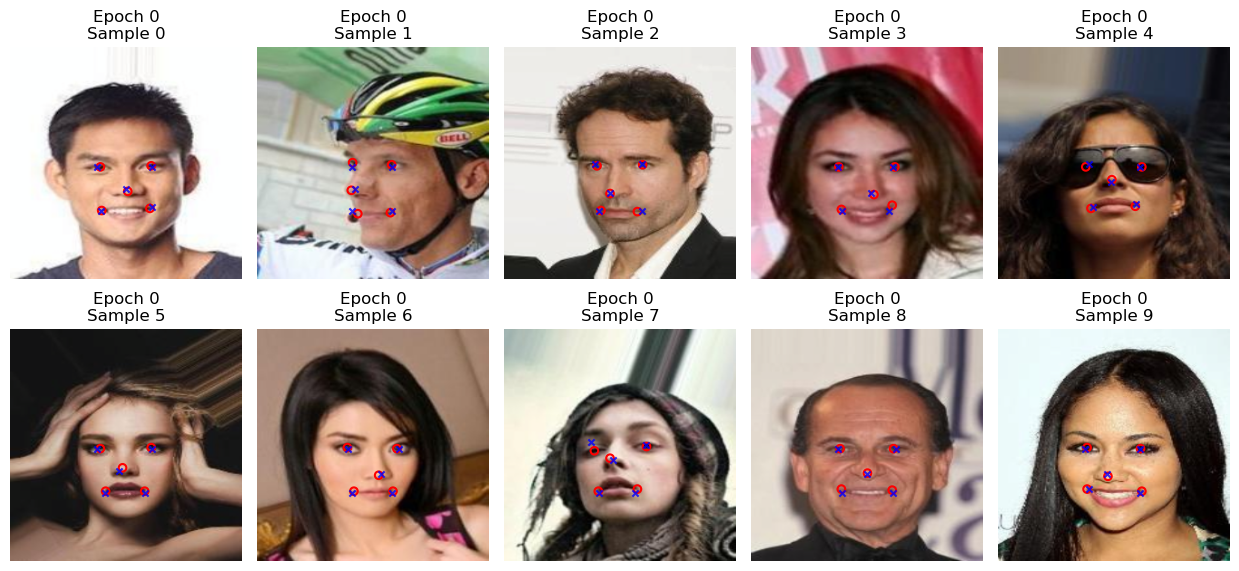

Validating: 100%|██████████| 8/8 [00:04<00:00,  1.84it/s, loss=0.00139] 


Epoch 2 - Train Loss: 0.0012, Val Loss: 0.0014, lr = 0.000005


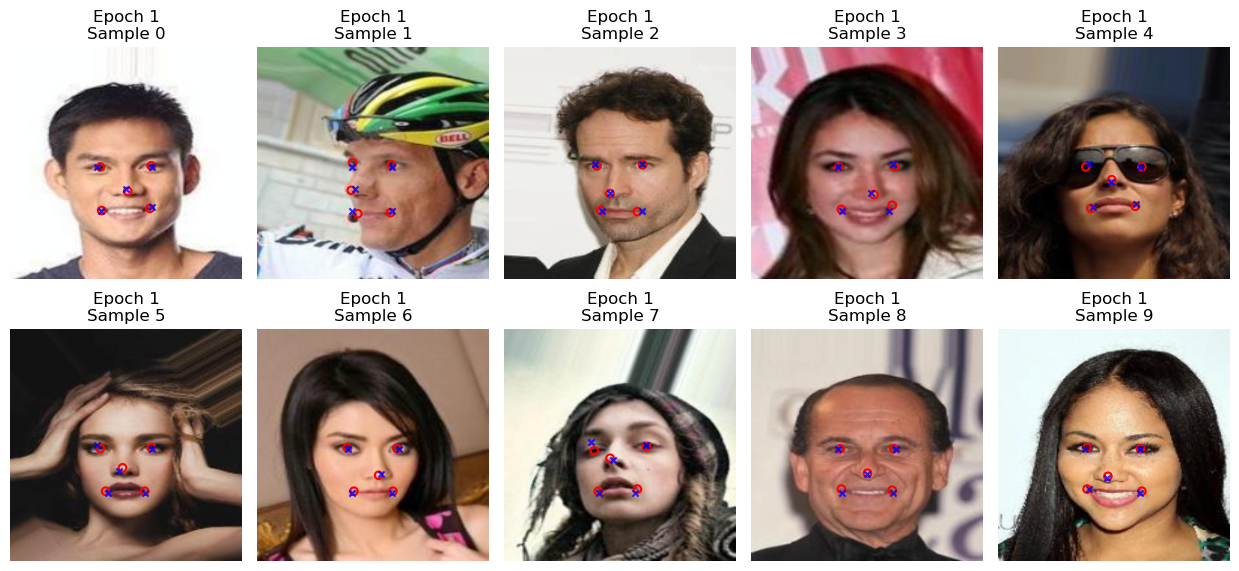

Validating: 100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.00142] 


Epoch 3 - Train Loss: 0.0012, Val Loss: 0.0013, lr = 0.000004


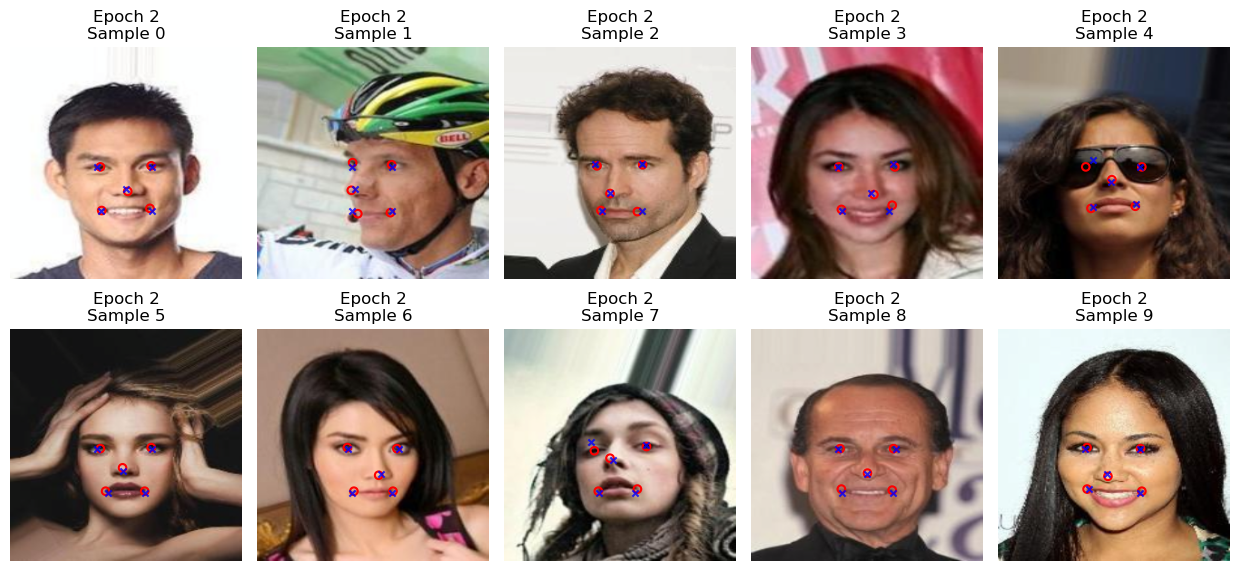

Validating: 100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.00138] 


Epoch 4 - Train Loss: 0.0011, Val Loss: 0.0013, lr = 0.000004


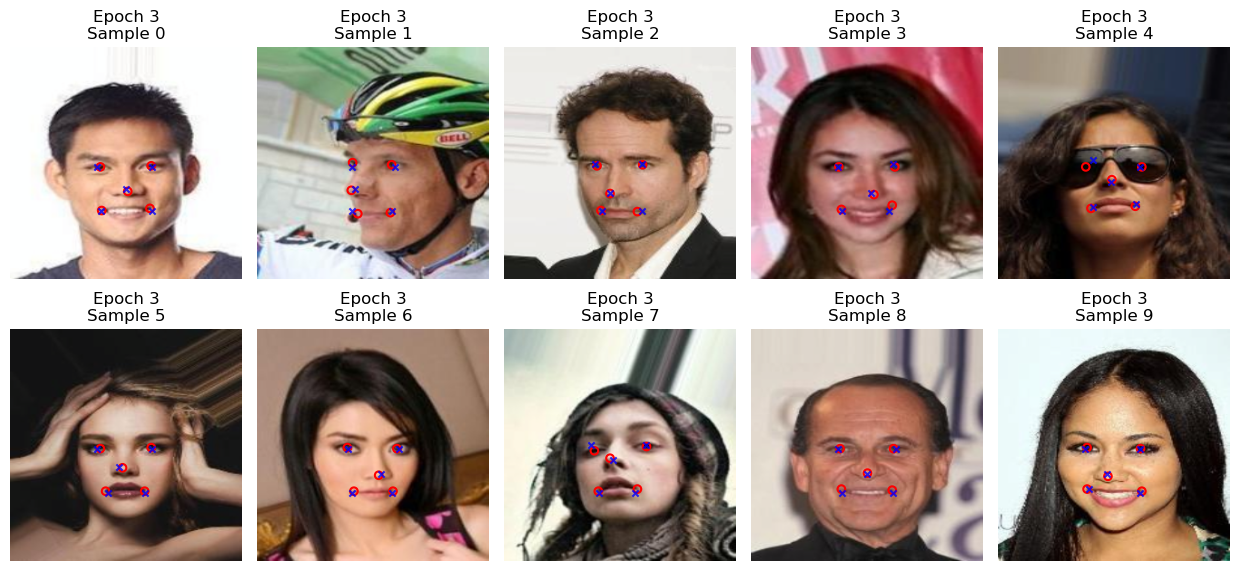

Validating: 100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.00137] 


Epoch 5 - Train Loss: 0.0011, Val Loss: 0.0013, lr = 0.000003


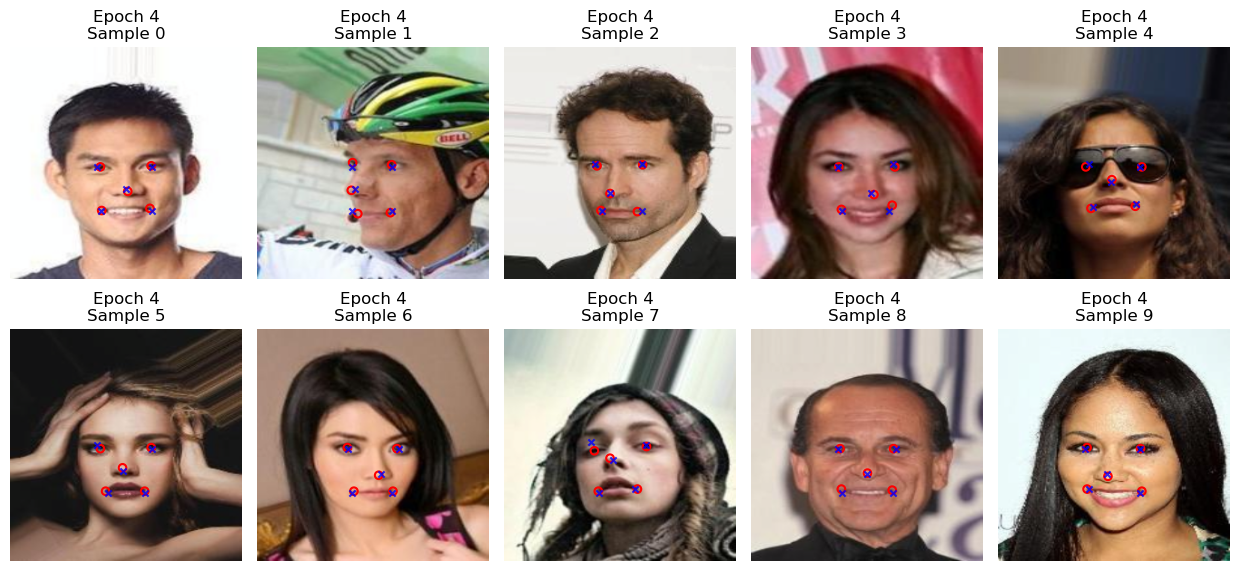

Validating: 100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.00148] 


Epoch 6 - Train Loss: 0.0011, Val Loss: 0.0014, lr = 0.000003


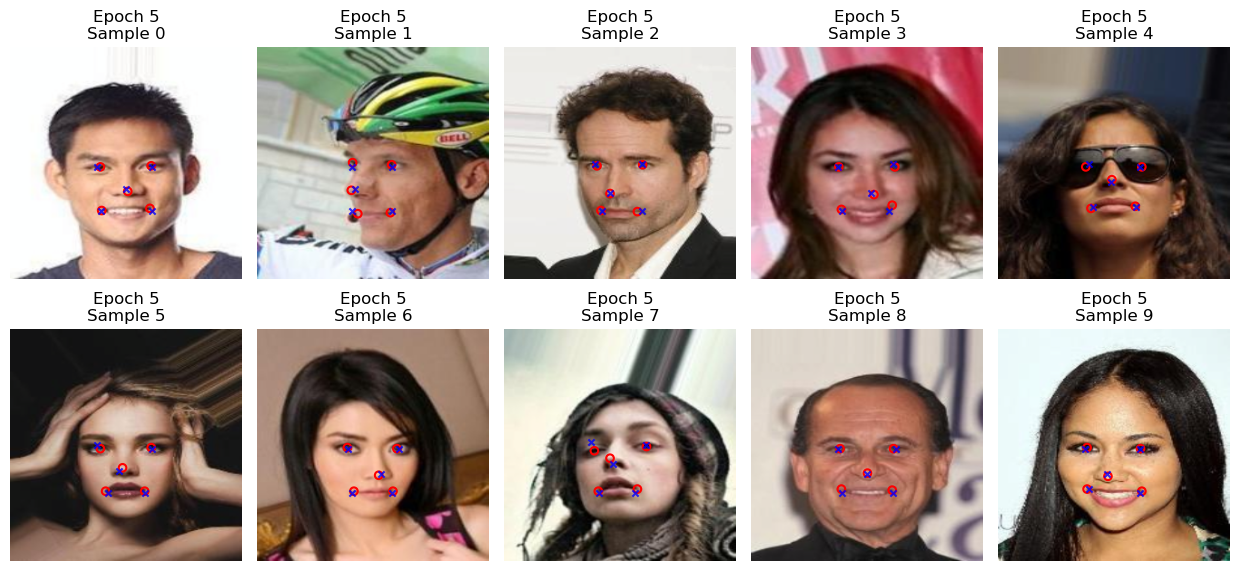

In [ ]:
# Цикл обучения

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    # Тренировка
    with tqdm(train_dataloader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
        for batch_idx, (images, gt_heatmaps, _) in enumerate(tepoch):
            images = images.to(device)
            gt_heatmaps = gt_heatmaps.to(device)
            
            # Forward pass
            pred_heatmaps_list = model(images)
            
            # Вычисляем лосс для каждой головы
            losses = [criterion(pred_heatmaps, gt_heatmaps) 
                     for pred_heatmaps in pred_heatmaps_list]
            total_loss = sum(losses)
            
            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            running_loss += total_loss.item()
            tepoch.set_postfix(loss=total_loss.item())
    
    # Валидация
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad(), tqdm(val_dataloader, desc="Validating") as vepoch:
        for images, gt_heatmaps, _ in vepoch:
            images = images.to(device)
            gt_heatmaps = gt_heatmaps.to(device)
            
            pred_heatmaps_list = model(images)
            batch_loss = sum([criterion(pred, gt_heatmaps) for pred in pred_heatmaps_list]).item()
            val_loss += batch_loss
            vepoch.set_postfix(loss=batch_loss)
    
    # Вывод статистики
    avg_train_loss = running_loss / len(train_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, lr = {current_lr:.6f}")
    
    # Визуализация после каждой эпохи
    with torch.no_grad():
        images, gt_heatmaps, gt_landmarks = next(iter(val_dataloader_visual))
        images = images.to(device)
        pred_heatmaps = model(images)[-1]
        
        img_vis = 10
        visualize_keypoints(images[:img_vis].cpu(),
                            gt_landmarks[:img_vis].cpu(),
                            pred_heatmaps[:img_vis].cpu(),
                            epoch)
        
    scheduler.step()  # StepLR просто уменьшает lr каждые N эпох

In [66]:
# Сохранение модели
torch.save(model.state_dict(), "hourglass_s5_10k_54epoch.pth")

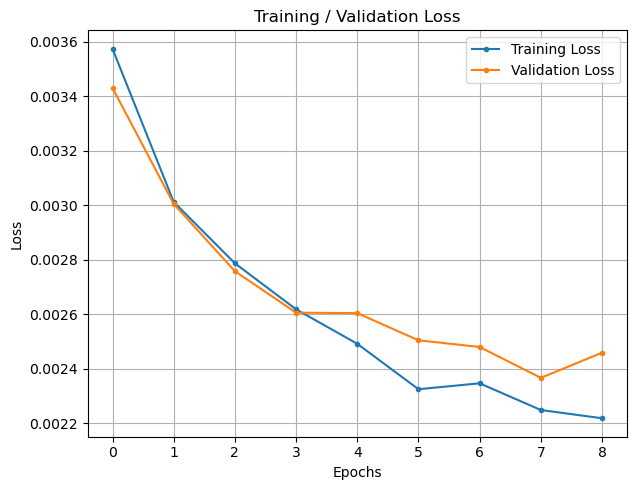

In [ ]:
# Визуализация Training / Validation Loss

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses[1:], label='Training Loss', marker='.')
plt.plot(val_losses[1:], label='Validation Loss', marker='.')

plt.title('Training / Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### 6. Face Alignment

In [ ]:
# Предсказание 5 ключевых точек из обученной модели

import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Предобработка — как при обучении
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def get_keypoints_from_image(img_path, model, device='cuda'):
    """
    Возвращает 5 ключевых точек (в координатах 256x256) для изображения.
    """
    model.eval()
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # (1, 3, 256, 256)

    with torch.no_grad():
        heatmaps = model(input_tensor)[-1]  # (1, 5, 64, 64)

    heatmaps = heatmaps.squeeze(0).cpu().numpy()  # (5, 64, 64)
    keypoints = []

    for hm in heatmaps:
        y, x = np.unravel_index(np.argmax(hm), hm.shape)
        keypoints.append([x * 4.0, y * 4.0])  # масштаб 64 -> 256

    keypoints = np.array(keypoints, dtype=np.float32)  # (5, 2)
    return keypoints


In [70]:
# Для align_face_pts порядок должен быть:  left_eye, right_eye, nose, left_mouth, right_mouth
# В файле list_landmarks_align_celeba.txt: left_eye, right_eye, nose, left_mouth, right_mouth
# OK !

import cv2
import numpy as np

def align_face_pts(img, pts5,
                   desired_left=(0.35, 0.4),
                   out_size=(224, 224),
                   desired_eye_dist=None):
    left, right = pts5[0], pts5[1]
    eyes_center = ((left + right) / 2).astype(np.float32)

    dx, dy = right - left
    angle = np.degrees(np.arctan2(dy, dx))
    dist = np.linalg.norm([dx, dy])

    if desired_eye_dist is None:
        desired_eye_dist = (1 - 2 * desired_left[0]) * out_size[0]
    scale = desired_eye_dist / dist

    M = cv2.getRotationMatrix2D(tuple(eyes_center), angle, scale)
    tX = out_size[0] * 0.5
    tY = out_size[1] * desired_left[1]
    M[0,2] += tX - eyes_center[0]
    M[1,2] += tY - eyes_center[1]

    return cv2.warpAffine(img, M, out_size, flags=cv2.INTER_CUBIC)

In [ ]:
# Визуализация результатов face alignment

def show_alignment_visual(val_dataset, model, device='cuda', num_samples=5):
    """
    Показывает до/после выравнивания лиц из val_dataset.
    """
    model.eval()
    indices = random.sample(range(len(val_dataset)), num_samples)
    
    before_imgs = []
    after_imgs = []

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    for idx in indices:
        image_tensor, _, _ = val_dataset[idx]  # (3, 256, 256)
        image = image_tensor.unsqueeze(0).to(device)

        # Предсказание
        with torch.no_grad():
            heatmaps = model(image)[-1]  # (1, 5, 64, 64)

        heatmaps = heatmaps.squeeze(0).cpu().numpy()
        keypoints = []

        for hm in heatmaps:
            y, x = np.unravel_index(np.argmax(hm), hm.shape)
            keypoints.append([x * 4.0, y * 4.0])

        keypoints = np.array(keypoints, dtype=np.float32)

        # Денормализуем изображение
        img_np = image_tensor.cpu().numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np * std + mean, 0, 1)
        
        # OpenCV: RGB → BGR
        img_bgr = (img_np[..., ::-1] * 255).astype(np.uint8)
        aligned = align_face_pts(img_bgr.copy(), keypoints)

        # Первый ряд: оригинал + точки
        before_imgs.append((img_np, keypoints))
        # Второй ряд: выравненное
        after_imgs.append(aligned[..., ::-1])  # BGR → RGB

    # Визуализация
    fig, axes = plt.subplots(2, num_samples, figsize=(3 * num_samples, 6))

    for i in range(num_samples):
        # Верхний ряд — исходное с точками
        img, pts = before_imgs[i]
        axes[0, i].imshow(img)
        axes[0, i].scatter(pts[:, 0], pts[:, 1], c='red', s=25)
        axes[0, i].set_title("До")
        axes[0, i].axis('off')

        # Нижний ряд — выровненное
        axes[1, i].imshow(after_imgs[i] / 255.0)
        axes[1, i].set_title("После")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

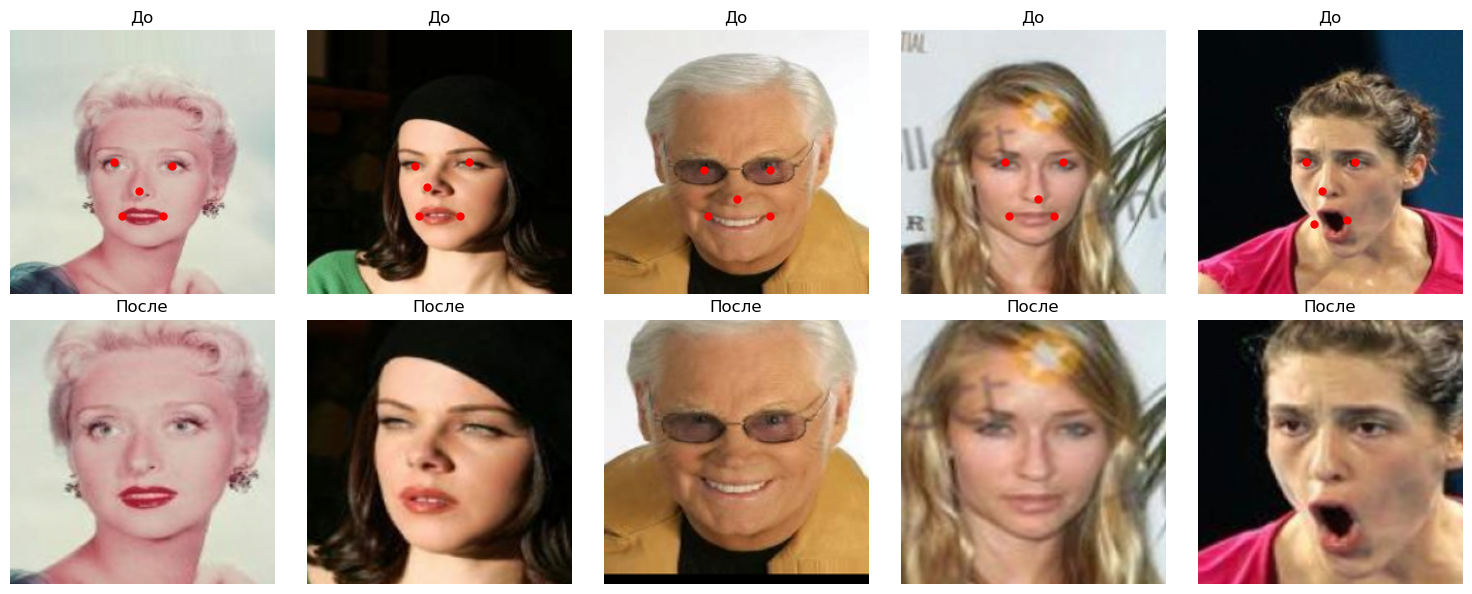

In [ ]:
show_alignment_visual(val_dataset, model, device='cuda')

## Выводы

Модель с архитектурой Stacked Hourglass Network Обучал локально на Nvidia RTX 3090, батч 64 картинки. Такой бач съедает 12-13 ГБ видеопамяти. Ядро GPU загружено на 5-8%, время обучения - 2 мин на эпоху. Начинайл с 1000 картинок для обучения и больших скоростей обучения, 5-8 эпох. Скорость постепенно убавлял и увеличил обучающий датасет до 10240 изображений.

scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

При n_stacks = 4 скорость обучения падала с существенным увеличением потребления видеопамяти, поэтому выбрал n_stacks = 2.
Модель быстрее учится при размере гауссова ядра для heatmap sigma = 5 и batch = 64. 10k картинок и 24 эпохи обучения дают Val Loss: 0.0014 и неплохой результат даже на развёрнутых лицах.

Параметры обучения:

 - n_stacks = 2     Число стеков в модели: 2 или 4
 - n_keypoints = 5  Число ключевых точек
 - sigma = 5        Размер гауссова ядра для heatmap
 - batch = 64       Количество изображений в одном баче

При тестировании на реальных фотографиях важно использовать кропы того же размера, что и изображения, использовавшиеся при обучении модели. В противном случае качество распознавания может значительно ухудшиться.